In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

# Introduction

#### Aim

Extract the HQ curves of the Heart Mate 3 device, for different RPMs. We constraint the curves to be polynomials of degree two.

<img src="../res/HQ-curve-HMIII.png" width="60%"/>

# Curve coefficients

#### Report data points


In [2]:
# Dictionnary: RPM [int] -> data [list of xs [list] and ys[list] ]
# x = Q, y = P
data = {}

In [3]:
data[3000] = [
    [0.0, 1.0, 2.0, 2.9], # flow
    [32,  29, 23, 14],   # pressure
]

In [4]:
data[4000] = [
    [0.0, 2.0, 3.0, 4.5],
    [58,  49,  41,  16]
]

In [5]:
data[5000] = [
    [0.0, 2.0, 4.0, 6.0],
    [90,  80,  63,  19]
]

In [6]:
data[6000] = [
    [0.0, 2.0, 4.0, 6.0, 7.0, 7.4],
    [131, 120, 105, 70,  36,  22]
]

In [7]:
data[7000] = [
    [0.0, 2.0, 4.0, 5.0, 8.0],
    [177, 168, 150, 140, 63]
]

In [8]:
data[8000] = [
    [0.0, 2.0, 3.0, 5.0, 6.0, 8.0, 10.0],
    [232, 220, 211, 191, 178, 126, 43]
]

In [9]:
data[9000] = [
    [0.0, 2.0, 4.0, 6.0, 9.0, 10.0, 11.0],
    [290, 278, 263, 240, 164, 125,  72]
]

#### Adjust units

The reported flow rate values are in $L/min$, while the model assumes $ml/s$. Thus we have to multiply every measure of $Q$ by $1000/60$.

In [10]:
for RPM in data:
    data[RPM] = np.array(data[RPM])
    data[RPM][0] = data[RPM][0] * 1000 / 60

## Fit polynomials


#### Procedure 

1. We reconstruct the HQ curve with the same axes as the original plot, as a mean of comparison
2. We reconstruct the HQ curve with **inverted axes**,
    * i.e. we perform polynomial regression with P as the input and Q as the output

#### Demo

[ 1.22017354  0.11388286 -0.0835141 ]


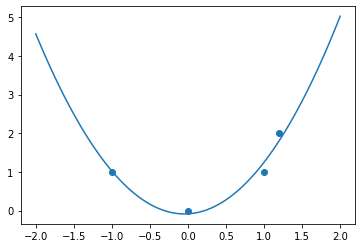

In [11]:
# Demo numpy.polyfit: f(x)=x^2
x = [-1,0,1, 1.2]
y = [1,0,1, 2]
coefs = np.polyfit(x, y, 2)
coefs # order: x^n, x^n-1, ..., x^1, x^0
print(coefs)
plt.scatter(x, y)
x = np.linspace(-2, 2, 100)
plt.plot(x, np.polyval(coefs, x));

#### Compute coefficients of the polynomials

In [12]:
# Pressure in function of flow
coefs = {}
# Flow in function of pressure
coefs_rev = {}

for k in data:
    x = data[k][0]
    y = data[k][1]
    coefs[k] = np.polyfit(x, y, deg=2)
    coefs_rev[k] = np.polyfit(y, x, deg=2)

In [13]:
coefs

{3000: array([-6.41965766e-03, -5.96681677e-02,  3.19451487e+01]),
 4000: array([-7.71827707e-03,  2.58323632e-02,  5.77991851e+01]),
 5000: array([-7.65e-03,  7.50e-02,  8.90e+01]),
 6000: array([-8.36547556e-03,  1.92188722e-01,  1.28446363e+02]),
 7000: array([-7.16105290e-03,  1.20669563e-01,  1.75321748e+02]),
 8000: array([-7.83343555e-03,  2.41598816e-01,  2.25995876e+02]),
 9000: array([-7.58147075e-03,  2.83673726e-01,  2.83909077e+02])}

In [14]:
coefs_rev

{3000: array([-0.12205387,  3.00925926, 29.88636364]),
 4000: array([-4.88034086e-02,  1.84837429e+00,  5.77709507e+01]),
 5000: array([-2.45944445e-02,  1.29678032e+00,  8.40811870e+01]),
 6000: array([-1.21526186e-02,  8.19382568e-01,  1.07021624e+02]),
 7000: array([-1.37201995e-02,  2.16110226e+00,  5.14744398e+01]),
 8000: array([-5.53127232e-03,  7.05034781e-01,  1.43812490e+02]),
 9000: array([-4.29159884e-03,  8.05248158e-01,  1.41178920e+02])}

#### HQ plot

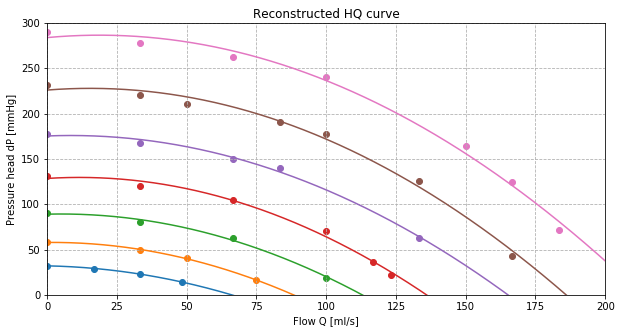

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
Qmax = 12 * 1000/60
Q = np.linspace(0, Qmax, 1000)

for RPM, coef in coefs.items():
    plt.scatter(data[RPM][0], data[RPM][1])
    plt.plot(Q, np.polyval(coef, Q))

plt.xlim(0, Qmax); plt.ylim(0, 300); plt.grid(ls='--');
plt.xlabel("Flow Q [ml/s]"); plt.ylabel("Pressure head dP [mmHg]");
plt.title("Reconstructed HQ curve");

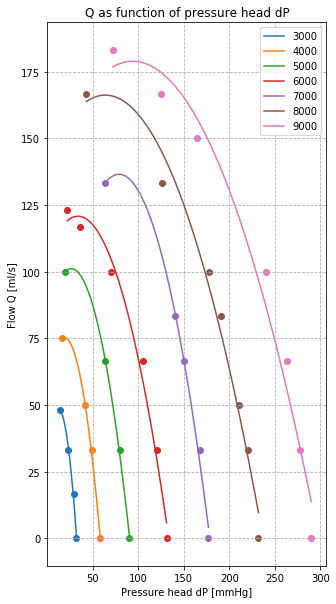

In [16]:
fig,ax = plt.subplots(1,1,figsize=(5, 10))
for RPM, coef in coefs_rev.items():
    pmin = min(data[RPM][1])
    pmax = max(data[RPM][1])
    dP = np.linspace(pmin, pmax, 1000)
    Q = np.polyval(coef, dP)
    plt.scatter(data[RPM][1], data[RPM][0])
    plt.plot(dP, Q, label=RPM)
    
plt.xlabel("Pressure head dP [mmHg]"); plt.ylabel("Flow Q [ml/s]"); plt.legend();
plt.grid(ls='--'); plt.title("Q as function of pressure head dP");

# Compare HQ curve of HM2

## Coefficients

Code in the modelica file `VAD`:

```
Q = if RPM == 10000 then min(306.65 - 4.03 * dP + 0.0127 * dP ^ 2, 133) else if RPM == 9000 then min(245.16 - 3.6 * dP + 0.0119 * dP ^ 2, 116.667) else if RPM == 8000 then min(195.85 - 3.506 * dP + 0.0136 * dP ^ 2, 100) else 0;```


In [17]:
coef = {}
mins = {}

In [18]:
coef[10000] = [0.0127, -4.03, 306.65]
coef[9000]  = [0.0119, -3.6,  245.16]
coef[8000]  = [0.0136, -3.506, 195.85]

In [19]:
mins[10000] = 133
mins[9000] = 116.667
mins[8000] = 100

## Plotting without `min` applied

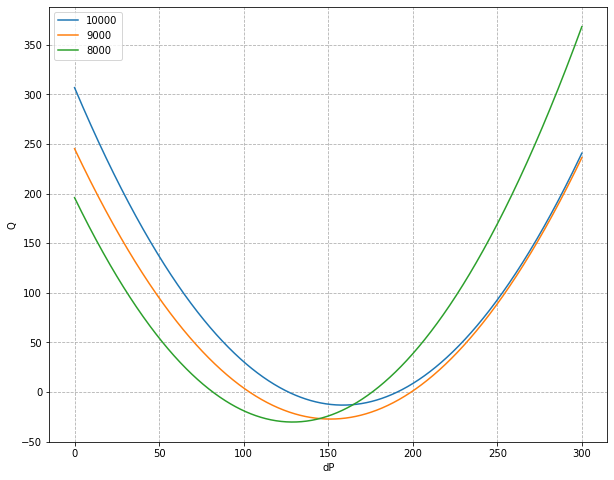

In [20]:
dP = np.linspace(0, 300, 1000)
plt.subplots(1,1,figsize=(10, 8))

for elem in coef :
    Q = np.polyval(coef[elem], dP)
    plt.plot(dP, Q, label=elem)

plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend();

## Apply `min`

In [21]:
curves = {}
dP = np.linspace(0, 300, 1000)
for elem in coef :
    Q = np.polyval(coef[elem], dP)
    curves[elem] = Q

In [22]:
# Apply the min
curves_corrected = {}
for RPM in curves : 
    curves_corrected[RPM] = [ min(mins[RPM], q) for q in curves[RPM] ]

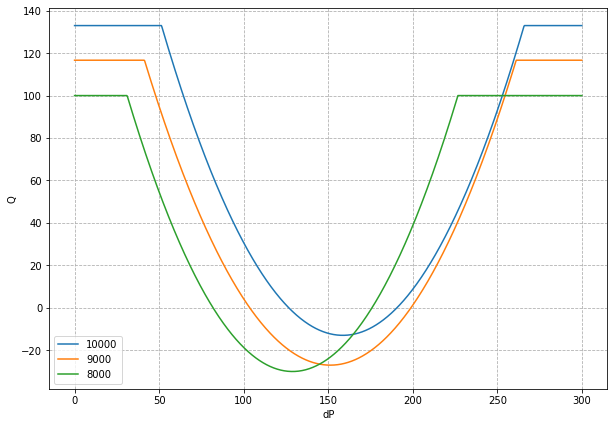

In [23]:
plt.subplots(1,1,figsize=(10,7))
dP = np.linspace(0, 300, 1000)
for RPM in curves_corrected:
    plt.plot(dP, curves_corrected[RPM], label=RPM)
    
plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend();

# Reconsider the range of values for `dP`

<img src="../res/LVAD_dP.png" style="width:50%"/>

The blue curve `LVAD2.dP` on top of is HM3, the red curve `LVAD.dP` is for HM2.

## HM2 HQ curve restricted in the observed dP range

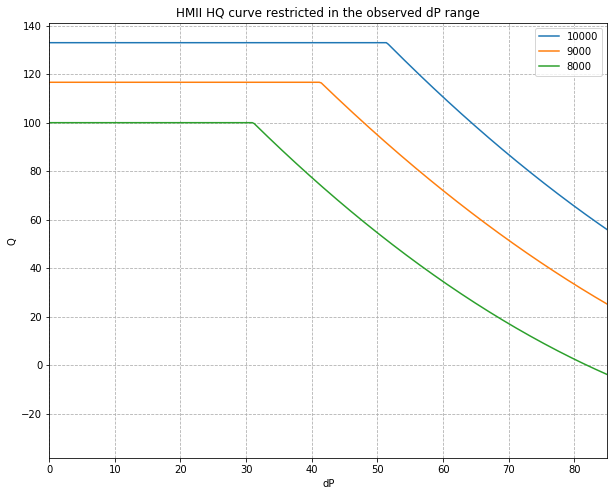

In [24]:
dPmax = 85
plt.subplots(1,1,figsize=(10, 8))
for RPM in curves_corrected : 
    plt.plot(dP, curves_corrected[RPM], label=RPM)
    
plt.grid(ls='--'); plt.xlabel("dP"); plt.ylabel("Q");
plt.legend(); plt.xlim(0, dPmax);
plt.title("HMII HQ curve restricted in the observed dP range");

## HM3 HQ curve: Determine points where Q start to decrease

Given $Q = a_2 x^2 + a_1 x + a_0$, with x=dP, we calculate points where $Q'(x) = 0$, i.e. we calculate the x s.t. $x = - \frac{a_1}{2a_2}$

In [25]:
dP_critical = {}

for RPM in coefs_rev : 
    dP_critical[RPM] = - coefs_rev[RPM][1] / (2 * coefs_rev[RPM][0])
print(dP_critical)

{3000: 12.327586206896544, 4000: 18.936938447758124, 5000: 26.363277370964347, 6000: 33.71218154391415, 7000: 78.7562258994521, 8000: 63.73170049641598, 9000: 93.81680219082028}


(dP_crit, Q_crit) = (12.327586206896544, 48.4348151050738)
(dP_crit, Q_crit) = (18.936938447758124, 75.27222580066713)
(dP_crit, Q_crit) = (26.363277370964347, 101.1748766624056)
(dP_crit, Q_crit) = (33.71218154391415, 120.83321099326314)
(dP_crit, Q_crit) = (78.7562258994521, 136.57456874024734)
(dP_crit, Q_crit) = (63.73170049641598, 166.2790227132171)
(dP_crit, Q_crit) = (93.81680219082028, 178.95182350051752)


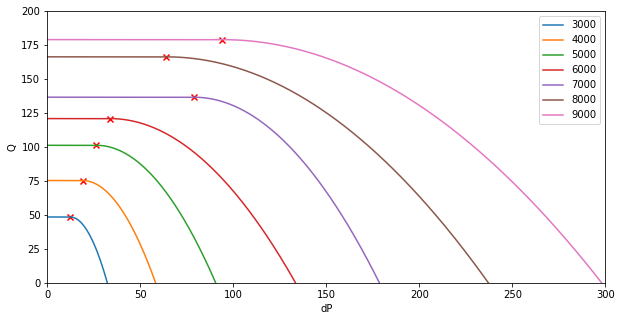

In [28]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

dPmax_HMIII = 300
dP = np.linspace(0, dPmax_HMIII, 1000)


for RPM in dP_critical : 
    # Compute Q
    Q = np.polyval(coefs_rev[RPM], dP)
    # Compute the points where Q begins to decrease
    a0, a1, a2 = coefs_rev[RPM][2], coefs_rev[RPM][1], coefs_rev[RPM][0]
    crit = dP_critical[RPM]
    q_crit = a0 + a1 * crit + a2 * crit ** 2
    # Once Q starts to decrease, set a constant
    Q = [ q if dP[i] >= crit else q_crit for i,q in enumerate(Q) ]
    
    print("(dP_crit, Q_crit) = ({}, {})".format(crit, q_crit))
    # Plot the cross marker
    plt.scatter(crit, q_crit, marker='x', color="red")
    ## Plot the curve
    plt.plot(dP, Q, label=RPM)
    
plt.xlim(0, dPmax_HMIII); plt.ylim(0, 200); plt.legend();
plt.xlabel("dP"); plt.ylabel("Q");

<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br />